### This notebook takes about 1.5 hours to run

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab
import copy

###
from itertools import islice
from moviepy.editor import ImageSequenceClip
from moviepy.video.io.bindings import mplfig_to_npimage

from matplotlib import pylab as plt
from matplotlib.cm import binary
from collections import Counter
from tqdm import tqdm
from scipy import stats
from collections import Counter

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class LatticeCell:
    """
    The general class for the lattice cells
    value: the value which indicates whether the cell is a wall or empty
    """
    def __init__(self, value):
        self.CA_value = value
        self.incoming_particles = []# the particles coming to the cell
        self.particle_contained = [] # the particles contained in that cell at any time step
        self.vectors = np.array([False,False, False, False, 
                                 False,False, False]) # the vectors of the particles that indicate the direction
    def get_value(self):
            """
            This function updates the value of cells to be visualized
            """
            return len(self.particle_contained)

In [3]:

def initialize(dimension):
    """
    initialize the model with the walls 
    """
    rows =columns = dimension
    config = np.zeros((rows, columns)).astype(object) 
    show_config = np.zeros((rows, columns))
    for i in range(rows):
        for j in range(columns):
            if i==0 or i==rows-1 or j==0 or j== columns-1:
                config[i, j] = LatticeCell(2)
                show_config[i, j] = 7
            else:
                config[i, j] = LatticeCell(0)
                show_config[i, j] = config[i, j].get_value()
            
     
    return config, show_config

def observe(config):
    
    """
    A function to visualize the grid
    """
    
    plt.figure(figsize = (10, 8))
    pylab.cla()
    pylab.imshow(config, vmin = 0, vmax = 7, cmap = pylab.cm.binary)

In [4]:
class Particle:
    """
    A class for the particles
    destination: the next cell for the particle
    vector: the vector that indicates the destination of the particle
    """
    def __init__(self, position, vector):
        self.position = position 
        self.destination = None
        self.vector = vector 

In [5]:
def fill_random(dimension, global_density, local_density, config, show_config):
    """
    A function to randomly fill the 2D grid.
    The function takes as input the dimensions, and the density. The global density is how many cells to be filled
    and the local density is how many particles per cell
    """
    rows = columns = dimension
    particles = [] # list to carry the particles
    for row in range(1,rows-1):
        for column in range(1, columns-1):
            if random.uniform(0, 1) < global_density: # how many cells to fill
                num = round(stats.norm(local_density, 1).rvs(1)[0])
                if num > 6: # number of particles per cell with a max of 6
                    num =6
                elif num < 0:
                    num = 0
                indices = random.sample([0, 1, 2, 3, 4, 5], num)
                config[row, column].vectors[indices] = True
                
                
                local_particles = [Particle([row, column], vector) for vector in indices]
                particles +=local_particles
                config[row, column].particle_contained += local_particles
                show_config[row, column] =config[row, column].get_value()
     
    return config, particles, show_config

In [6]:
def get_next(dimension, row, column, vector):
    """
    A function to get the coordinates of the next cell based on the coordinates of the current cell
    dimension: the dimensions of the grid
    row, column: coordinates of the cell
    vector: the direction at which the next cell is needed
    """
    rows= columns = dimension
    
    if vector == -1:
        new_row,new_column = [row, column] #rest
    
    elif vector == 0:
        new_row,new_column = [(row-1)%rows, column] #top
        
    elif vector == 1:
        new_row,new_column = [(row-1)%rows, (column +1)%columns] #top right
        
    elif vector == 2:
        new_row,new_column = [(row+1)%rows, (column+1)%columns] #Bottom Right
        
    elif vector == 3:
        new_row,new_column = [(row+1)%rows, column] #bottom
        
    elif vector == 4:
        new_row,new_column = [(row+1)%rows, (column -1)%columns] #bottom left
        
    elif vector == 5:
        new_row,new_column = [(row-1)%rows, (column-1)%columns] #top left
    return new_row,new_column 


def get_all_neighbors(dimension, row, column):
    """
    A function to get all the neighbors of a given cell
    """
    rows, columns  = dimension
    all_neighbors = []
    
    all_neighbors.append([row, column]) #rest

    all_neighbors.append([(row-1)%rows, column]) #top

    all_neighbors.append([(row-1)%rows, (column +1)%columns]) #top right

    all_neighbors.append([(row+1)%rows, (column+1)%columns]) #Bottom Right

    all_neighbors.append([(row+1)%rows, column]) #bottom

    all_neighbors.append([(row+1)%rows, (column -1)%columns]) #bottom left

    all_neighbors.append([(row-1)%rows, (column-1)%columns]) #top left
        
    return all_neighbors



                
                
def change_position(config, show_config,row, column):
    """
    This function accounts for the dilatency effect. When particles are pressued, they get moved out 
    of the pressured region
    """
    
    if len(config[row, column].particle_contained)>1:
        
        if [i.vector for i in config[row, column].particle_contained].count(-1) >1:
            
            scattering_particles = [particle for particle in config[row, column].particle_contained if\
                                   particle.vector ==-1]

            NNs = get_all_neighbors(len(config),row, column)
            for particle in scattering_particles[:-1]:
                
                available = [i for i in NNs if (config[i[0], i[1]].vectors[-1]==False and config[i[0], i[1]].CA_value!=2)]
                if available:
                    new_row, new_column = random.choice(available)
                    particle.position = [new_row, new_column]
                    config[row, column].particle_contained.remove(particle)
                    config[row, column].vectors[particle.vector] = False
                    show_config[row, column] = config[row, column].get_value()
                   
                
                
                    
                    config[new_row, new_column].CA_value = 1
                    config[new_row, new_column].particle_contained.append(particle)
                    config[new_row,new_column].vectors[particle.vector] = True
                    show_config[new_row,new_column] = config[new_row,new_column].get_value()
                    

          
gravity_vector = {0: -1, -1: 3, 1:2, 2:3, 5:4, 4:3, 3:3} # this for the particles that bounce in the opposite direction
def add_gravity(particle):
    """
    The gravity effect
    """
    
    particle.vector = gravity_vector[particle.vector]
    

In [7]:
# ignore the following paramters since they are for the more advanced granular model. They are basically
# dissipation and gravity but I set them to 0 because I don't use them yet.
g = 0
p2 = 0 # disspation of rest particles
p3 = 0 # dissipation of walls
b = 0.5
p=0.0
def propagation_step(config, show_config, particles):
    """
    The update step that I explained in the report. It gets the cells at which colliison happens
    particles: a list of all particles
    """
    
    moving_particles = []
    active_sites = []
    collision_sites = [] #when more than 1 particle approach a site

    # get all the destinations and add each particle to the incoming of its going cell
    # and store the active sites that will have particles
    for my_particle in particles:
        
       
        row, column = my_particle.position
        new_row,new_column = get_next(len(config), row, column, my_particle.vector) 
        my_particle.destination = [new_row,new_column]
        #if my_particle not in config[new_row,new_column].incoming_particles:
        config[new_row,new_column].incoming_particles.append(my_particle)
        if [new_row,new_column] not in active_sites:
            active_sites.append([new_row,new_column])
        
    #go through each active site and see if collision is happening there
    for row, column in active_sites:
        
        #wall
        if config[row, column].CA_value ==2:
            collision_sites.append([row, column])
        #two-body    
        elif len(config[row, column].incoming_particles) ==2:
            one, two = config[row, column].incoming_particles
            X = max(one.vector, two.vector)
            Y = min(one.vector, two.vector)
            distance = min(X-Y, 5-(X-Y-1))
            
            #
            if one.vector ==-1 or two.vector ==-1 or distance ==3 or distance ==2:
                  
                if one.position != two.position:
                    collision_sites.append([row, column])    
                else:
                    moving_particles = moving_particles+ config[row, column].incoming_particles
                    
            else:
                moving_particles = moving_particles+ config[row, column].incoming_particles
        
        #three-body
        elif len(config[row, column].incoming_particles) ==3:
            vectors = sorted([i.vector for i in config[row, column].incoming_particles])
            if [0,2,4] ==vectors or [1, 3, 5] == vectors:
                collision_sites.append([row, column])
            elif -1 in vectors:
                config[row, column].incoming_particles.sort(key=lambda x: x.vector)
                one, two, three = config[row, column].incoming_particles#to get the -1
                X = three.vector
                Y = two.vector
                distance = min(X-Y, 5-(X-Y-1))
                if distance ==2 or distance ==3:
                    collision_sites.append([row, column])
                else:
                    moving_particles = moving_particles+ config[row, column].incoming_particles   
            else:
                moving_particles = moving_particles+ config[row, column].incoming_particles   
 
        
        else:
            moving_particles = moving_particles+ config[row, column].incoming_particles
     
    #for all particles that are not colliding, propagate them ahead
    
    #print([particle.position for particle in moving_particles if moving_particles.count(particle)>1])
    for move_particle in moving_particles:
        row, column = move_particle.position
        new_row,new_column = move_particle.destination
        config[row, column].particle_contained.remove(move_particle)
        #config[row, column].vectors[move_particle.vector] = False
        #show_config[row, column] = config[row, column].get_value()
        if not config[row, column].particle_contained:
            config[row, column].CA_value = 0
            config[row, column].vectors[move_particle.vector] = False
            show_config[row, column] = config[row, column].get_value()
        elif move_particle.vector not in [i.vector for i in config[row, column].particle_contained]:
            config[row, column].vectors[move_particle.vector] = False
            show_config[row, column] = config[row, column].get_value()
        
            
        config[new_row,new_column].particle_contained.append(move_particle)
        config[new_row,new_column].CA_value = 1
        config[new_row,new_column].vectors[move_particle.vector] = True
        show_config[new_row,new_column] = config[new_row,new_column].get_value()
        
        config[new_row,new_column].incoming_particles = []
        move_particle.position = [new_row,new_column]
        move_particle.destination = None
    
    
        
    return config, show_config, particles, collision_sites

In [8]:
def scattering(config, show_config,pressuring_cells):
    """
    This function uses the "change_position" function to do the dilatency effect
    config, show_config: the 2d grid for updating and printing
    pressuring_cells: the cells with high density
    """
    for row, column in pressuring_cells:
        if len(config[row, column].particle_contained) >1:
            change_position(config, row, column)
        else:
            pressuring_cells.remove([row, column])
    return config, pressuring_cells        

In [9]:

mirror_vector = {0:3, 3:0, 1:5, 5:1, 4:2, 2:4} # for particles bouncing in the opposite direction

def collision_step(config, show_config,collision_sites, pressured_cells):
    """
    the function that changes the vectors after collision
    
    """
    
    for site in collision_sites:
       
        row, column = site
        
        #wall collision
        if config[row, column].CA_value == 2:
            
            
            for particle in config[row, column].incoming_particles:
                curr_row, curr_column = particle.position
                if [i.vector for i in config[curr_row, curr_column].particle_contained].count(particle.vector)==1 :
                  
                    config[curr_row, curr_column].vectors[particle.vector] = False
                    show_config[curr_row, curr_column]  = config[curr_row, curr_column].get_value()
                if random.uniform(0, 1) < p3:
                    particle.vector =-1
                else:
                    
                    if random.uniform(0, 1) < b:
                        particle.vector = (particle.vector+3)%6

                    else:
                        particle.vector = mirror_vector[particle.vector]
                    
            
                config[curr_row, curr_column].vectors[particle.vector] = True
                show_config[curr_row, curr_column]  = config[curr_row, curr_column].get_value()
            config[row, column].incoming_particles = []
            
            
            
        # two-body collision    
        elif len(config[row, column].incoming_particles) == 2:
            #print("Tow Body Collision")
            
            # a particle with a rest particle
            if config[row, column].incoming_particles[0].vector==-1 or\
            config[row, column].incoming_particles[1].vector==-1:
                
                #knowing which one is the rest
                if config[row, column].incoming_particles[0].vector==-1:
                    rest_partic = config[row, column].incoming_particles[0]
                    collid_partic = config[row, column].incoming_particles[1]
                    #print(collid_partic.vector)
                elif config[row, column].incoming_particles[1].vector==-1:
                    rest_partic = config[row, column].incoming_particles[1]
                    collid_partic = config[row, column].incoming_particles[0]
                    #print(collid_partic.vector)
                else:
                    print("weirddd!!!!")
                    
               
                ## get them out:
                row_1, column_1 = collid_partic.position
                row_2, column_2 = rest_partic.position
                config[row_1, column_1].particle_contained.remove(collid_partic)
                config[row_2, column_2].particle_contained.remove(rest_partic)
                if collid_partic.vector not in [i.vector for i in config[row_1, column_1].particle_contained]:
                    config[row_1, column_1].vectors[collid_partic.vector] = False
                    show_config[row_1, column_1] = config[row_1, column_1].get_value()
                if rest_partic.vector not in [i.vector for i in config[row_2, column_2].particle_contained]:
                    config[row_2, column_2].vectors[rest_partic.vector] = False
                    show_config[row_2, column_2] = config[row_2, column_2].get_value()
                ##
                
                
                # pushing the rest down 
                in_vector = collid_partic.vector
                rrow_1, rcolumn_1 =  get_next(len(config),row, column, (in_vector)%6) 
                if not config[rrow_1, rcolumn_1].vectors[-1] :
                    
                    rest_partic.vector = (in_vector)%6
                    collid_partic.vector = -1
                    
                else:
            
                    collid_partic.vector = -1
                    
                    #else:
                     #   collid_partic.vector = random.choice([(in_vector+3)%6, (in_vector+2)%6, (in_vector+4)%6])

                config[row, column].incoming_particles = []
                
                ### get them in:
                    
                config[row, column].particle_contained+= [collid_partic, rest_partic]
                collid_partic.position = [row, column]
                rest_partic.position = [row, column]
                config[row, column].vectors[collid_partic.vector] =True
                config[row, column].vectors[rest_partic.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                #change_position(config, row, column)
                pressured_cells.append([row, column])
                ###
            
                
            else: #non-rest two-body
                
                ###########################
                particle_1 = config[row, column].incoming_particles[0]
                particle_2 = config[row, column].incoming_particles[1]
                
                ## get them out:
                row_1, column_1 = particle_1.position
                row_2, column_2 = particle_2.position
                config[row_1, column_1].particle_contained.remove(particle_1)
                config[row_2, column_2].particle_contained.remove(particle_2)
                if particle_1.vector not in [i.vector for i in config[row_1, column_1].particle_contained]:
                    config[row_1, column_1].vectors[particle_1.vector] = False
                    show_config[row_1, column_1] = config[row_1, column_1].get_value()
                if particle_2.vector not in [i.vector for i in config[row_2, column_2].particle_contained]:
                    config[row_2, column_2].vectors[particle_2.vector] = False
                    show_config[row_2, column_2] = config[row_2, column_2].get_value()
                ##
                

                X = max(particle_1.vector, particle_2.vector)
                Y = min(particle_1.vector, particle_2.vector)
                distance = min(X-Y, 5-(X-Y-1))
                #config[row, column].incoming_particles = []
                
                # head-on collision
                if distance == 3 :
                    
                    if random.uniform(0, 1) < 0.5:
                        particle_1.vector = (particle_1.vector+1)%6
                        particle_2.vector = (particle_2.vector+1)%6
                        config[row, column].incoming_particles = []
                    else:
                        particle_1.vector = (particle_1.vector-1)%6
                        particle_2.vector = (particle_2.vector-1)%6
                        config[row, column].incoming_particles = []

                # angle collision
                # p
                elif distance == 2 :
                    if (particle_1.vector +2)%6 ==  particle_2.vector:
                        i = particle_1
                        i_2 = particle_2
                    else:
                        i = particle_2
                        i_2 = particle_1
                    
                    if random.uniform(0, 1) <= p:
                        i.vector = (i.vector+3)%6
                        i_2.vector = (i_2.vector+3)%6
                        i_2.vector = (i.vector-2)%6
                        i.vector = -1
                        
                        
                        
                        config[row, column].incoming_particles = []
                        #print("rest")

                    else:
                        
                        #print("Mirror")
                        i.vector, i_2.vector = i_2.vector,i.vector 
                        
                        config[row, column].incoming_particles = []

                else:
                    print(particle_1.vector, particle_2.vector)
                    #     config[row, column].CA_value)
                    #print(particle_1.sec_vector[-6:], particle_2.sec_vector[-6:])
                    #print("---")
                
                ### get them in:    
                config[row, column].particle_contained+= [particle_1, particle_2]
                particle_1.position = [row, column]
                particle_2.position = [row, column]
                config[row, column].vectors[particle_1.vector] =True
                config[row, column].vectors[particle_2.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                ###
                
                
        #three-body collisions            
        elif len(config[row, column].incoming_particles) == 3:
            vectors = sorted([i.vector for i in config[row, column].incoming_particles])
            
            #non-rest three-body
            if [0,2,4] ==vectors or [1, 3, 5] == vectors:
                
                particle_1 = config[row, column].incoming_particles[0]
                particle_2 = config[row, column].incoming_particles[1]
                particle_3 = config[row, column].incoming_particles[2]
                
               
                ## get them out:
                row_1, column_1 = particle_1.position
                row_2, column_2 = particle_2.position
                row_3, column_3 = particle_3.position
                config[row_1, column_1].particle_contained.remove(particle_1)
                config[row_2, column_2].particle_contained.remove(particle_2)
                config[row_3, column_3].particle_contained.remove(particle_3)
                if particle_1.vector not in [i.vector for i in config[row_1, column_1].particle_contained]:
                    config[row_1, column_1].vectors[particle_1.vector] = False
                    show_config[row_1, column_1] = config[row_1, column_1].get_value()
                if particle_2.vector not in [i.vector for i in config[row_2, column_2].particle_contained]:
                    config[row_2, column_2].vectors[particle_2.vector] = False
                    show_config[row_2, column_2] = config[row_2, column_2].get_value()
                if particle_3.vector not in [i.vector for i in config[row_3, column_3].particle_contained]:
                    config[row_3, column_3].vectors[particle_3.vector] = False
                    show_config[row_3, column_3] = config[row_3, column_3].get_value()
                
                
                
                ##

               
                config[row, column].incoming_particles = []
                if random.uniform(0, 1) <p:
                    r = random.choice([1, 2, 3])
                    #print(r)
                    if r==1:
                        particle_2.vector = (particle_1.vector)%6  
                        particle_3.vector = (particle_1.vector+3)%6
                        particle_1.vector = -1
                        #change_position(config, particle_1)

                    elif r==2:
                        particle_2.vector = (particle_1.vector+2)%6  
                        particle_3.vector = (particle_1.vector-1)%6
                        particle_1.vector = -1
                        #change_position(config, particle_1)
                    elif r==3:
                        particle_2.vector = (particle_1.vector+1)%6  
                        particle_3.vector = (particle_1.vector-2)%6
                        particle_1.vector = -1
                        #change_position(config, particle_1)
                else:
                    
                    particle_2.vector = (particle_1.vector+1)%6  
                    particle_3.vector = (particle_1.vector-1)%6
                    particle_1.vector = (particle_1.vector+3)%6 
                    
                ### get them in:    
                config[row, column].particle_contained+= [particle_1, particle_2, particle_3]
                particle_1.position = [row, column]
                particle_2.position = [row, column]
                particle_3.position = [row, column]
                config[row, column].vectors[particle_1.vector] =True
                config[row, column].vectors[particle_2.vector] =True
                config[row, column].vectors[particle_3.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                ###
            
            #rest three-body
            elif -1 in vectors:
                config[row, column].incoming_particles.sort(key=lambda x: x.vector)
                one, two, three = config[row, column].incoming_particles#to get the -1
                
                ## get them out:
                row_1, column_1 = one.position
                row_2, column_2 = two.position
                row_3, column_3 = three.position
                config[row_1, column_1].particle_contained.remove(one)
                config[row_2, column_2].particle_contained.remove(two)
                config[row_3, column_3].particle_contained.remove(three)
                if one.vector not in [i.vector for i in config[row_1, column_1].particle_contained]:
                    config[row_1, column_1].vectors[one.vector] = False
                    show_config[row_1, column_1] = config[row_1, column_1].get_value()
                if two.vector not in [i.vector for i in config[row_2, column_2].particle_contained]:
                    config[row_2, column_2].vectors[two.vector] = False
                    show_config[row_2, column_2] = config[row_2, column_2].get_value()
                if three.vector not in [i.vector for i in config[row_3, column_3].particle_contained]:
                    config[row_3, column_3].vectors[three.vector] = False
                    show_config[row_3, column_3] = config[row_3, column_3].get_value()
                
                
                
                ##
                
                X = three.vector
                Y = two.vector
                distance = min(X-Y, 5-(X-Y-1))
                #head-on to rest
                if distance == 3:
                    if random.uniform(0, 1) < p:
                        one.vector = -1
                        two.vector = -1
                        three.vector = -1
                        
                    
                #angle to rest    
                else:
                    
                    one.vector = -1
                    three.vector = (two.vector+1)%6
                    two.vector = -1
                   
                
                config[row, column].incoming_particles = []    
                
                
                ### get them in:    
                config[row, column].particle_contained+= [one, two, three]
                one.position = [row, column]
                two.position = [row, column]
                three.position = [row, column]
                config[row, column].vectors[one.vector] =True
                config[row, column].vectors[two.vector] =True
                config[row, column].vectors[three.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                #change_position(config, row, column)
                pressured_cells.append([row, column])
                ###    
                
            
     
        
        
    return config, collision_sites, pressured_cells              
                    
    

In [10]:
import matplotlib
import matplotlib.animation as animation
from IPython.display import Video
import matplotlib as mpl

def build_animation(states, save_name):
    """
    A function that makes a very nice animation
    
    Source: https://stackoverflow.com/questions/17212722/matplotlib-imshow-how-to-animate
    """
    
    fps = 5
    nSeconds = len(states)// fps

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = states[0]



    pylab.cla()
    im = pylab.imshow(a, vmin = 0, vmax = 7, cmap = pylab.cm.binary)


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(states[i])
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = nSeconds * fps,
                                   interval = 1000 / fps, # in ms
                                   )

    anim.save(save_name, fps=fps, extra_args=['-vcodec', 'libx264'])

    print('Done!')



In [11]:
def fill_random(dimension, global_density, local_density, config, show_config):
    """
    Fill particles at random locations. Sam description as the one mentioned above
    """
    rows = columns = dimension
    particles = []
    for row in range(1,rows-1):
        for column in range(1, columns-1):
            if random.uniform(0, 1) < global_density:
                num = round(stats.norm(local_density, 1).rvs(1)[0])
                if num > 6:
                    num =6
                elif num < 0:
                    num = 0
                indices = random.sample([0, 1, 2, 3, 4, 5], num)
                config[row, column].vectors[indices] = True
                
                
                local_particles = [Particle([row, column], vector) for vector in indices]
                particles +=local_particles
                config[row, column].particle_contained += local_particles
                show_config[row, column] =config[row, column].get_value()
     
    return config, particles, show_config

In [12]:
def fill_random_2(dimension,N_particles, config, show_config):
    """
    Similar to the function above but it's used to intialize the 20x20 region microstate that I described in the model
    """
    rows = columns = dimension
    i_coords, j_coords = np.meshgrid(range(rows), range(columns), indexing='ij')
    coordinate_grid = np.array([i_coords, j_coords])
    all_coordinates = []
    for i in range(1, rows-1):
        for j in range(1, columns-1):
            all_coordinates.append(list(coordinate_grid[:, i, j]))
        
    samples = random.sample(all_coordinates, N_particles)
    particles = []

    for row, column in samples:
            
        num = 1
        indices = random.sample([0, 1, 2, 3, 4, 5], num)
        config[row, column].vectors[indices] = True


        local_particles = [Particle([row, column], vector) for vector in indices]
        particles +=local_particles
        config[row, column].particle_contained += local_particles
        show_config[row, column] =config[row, column].get_value()
  
    return config, particles, show_config

In [13]:
def simulation(dimension, N_particles):
    """
    A function to start the simulation
    """
    rows = columns = dimension
    config, show_config = initialize(dimension)
    #config, particles, show_config = fill_random(dimension, 0.5, 1, config, show_config)
    config, particles, show_config = fill_random_2(dimension, N_particles, config, show_config)

    
    vecc = np.vectorize(lambda x: len(x.particle_contained))

    states = []
    config_states = []
    states.append(vecc(config))
    config_states.append(copy.deepcopy(config))
    pressured_cells = []

    for i in tqdm(range(1000)):
        
        #states.append(np.copy(show_config))
        #config_states.append(copy.deepcopy(config))
        
        config, show_config, particles, collision_sites = propagation_step(config, show_config,particles)
        config, collision_sites, pressured_cells   = collision_step(config, show_config,collision_sites, pressured_cells)
        config, pressured_cells = scattering(config, show_config,pressured_cells)
        states.append(vecc(config))
        #states.append(np.copy(show_config))
        
    return states

In [14]:
# calculating all the possible coordinates to choose from randomly:
dimension = 50
rows = columns = dimension
i_coords, j_coords = np.meshgrid(range(20), range(20), indexing='ij')
coordinate_grid = np.array([i_coords, j_coords])
all_coordinates = []
for i in range(1, 20):
    for j in range(1, 20):
        all_coordinates.append(list(coordinate_grid[:, i, j]))

def fill_random_3(N_particles, config, show_config):
    """
    A function to fill particles randomly and start the 20x20 region
    """    
    samples = random.sample(all_coordinates, N_particles)
    particles = []

    for row, column in samples:
            
        num = 1
        indices = random.sample([0, 1, 2, 3, 4, 5], num)
        config[row, column].vectors[indices] = True


        local_particles = [Particle([row, column], vector) for vector in indices]
        particles +=local_particles
        config[row, column].particle_contained += local_particles
        show_config[row, column] =config[row, column].get_value()
  
    return config, particles, show_config

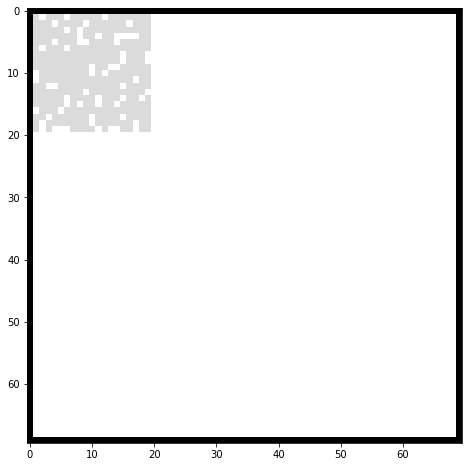

In [15]:
# the 20x20 region:
N_particles = 300
dimension = 70
rows = columns = dimension
config, show_config = initialize(dimension)
config, particles, show_config = fill_random_3(N_particles, config, show_config)

observe(show_config)

In [16]:
# let the model run with that 20x20 configuration:
rows = columns = dimension
config, show_config = initialize(dimension)
config, particles, show_config = fill_random_3(N_particles, config, show_config)


vecc = np.vectorize(lambda x: len(x.particle_contained) if x.CA_value!=2 else 7)

states = []
config_states = []
states.append(vecc(config))
config_states.append(copy.deepcopy(config))
pressured_cells = []

for i in tqdm(range(1000)):


    config, show_config, particles, collision_sites = propagation_step(config, show_config,particles)
    config, collision_sites, pressured_cells   = collision_step(config, show_config,collision_sites, pressured_cells)
    config, pressured_cells = scattering(config, show_config,pressured_cells)
    states.append(vecc(config))



100%|██████████| 1000/1000 [00:07<00:00, 142.43it/s]


.........................................................................................................................................................................................................Done!


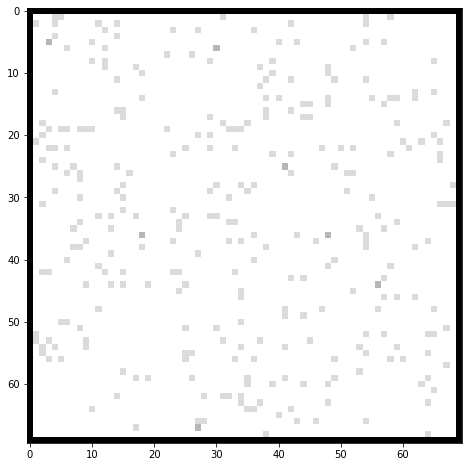

In [17]:
build_animation(states, "entropy.mp4")

In [18]:
from IPython.display import Video
Video("entropy.mp4")

In [19]:
# do the analysis to get the entropy:

N_particles = 300
dimension =50
rows = columns = dimension
config, show_config = initialize(dimension)
config, particles, show_config = fill_random_3(N_particles, config, show_config)
#config, particles, show_config = fill_random_2(dimension, N_particles, config, show_config)

#observe(show_config)

In [20]:
time_steps = 500
prob_counter = np.zeros(( time_steps+1, rows, columns))
count_vecc = np.vectorize(lambda x: 1 if x>0 else 0)

vecc = np.vectorize(lambda x: len(x.particle_contained))


for i in tqdm(range(10)):
    N_particles = 300
    rows = columns = dimension
    config, show_config = initialize(dimension)
    config, particles, show_config = fill_random_3(N_particles, config, show_config)
    states = []
    config_states = []
    states.append(vecc(config))
    config_states.append(copy.deepcopy(config))
    pressured_cells = []
    for i in range(time_steps):
        config, show_config, particles, collision_sites = propagation_step(config, show_config,particles)
        config, collision_sites, pressured_cells   = collision_step(config, show_config,collision_sites, pressured_cells)
        config, pressured_cells = scattering(config, show_config,pressured_cells)
        states.append(vecc(config))

    prob_counter+=  count_vecc(states)  

100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


In [21]:
entropies = []
def get_entropy(x):
    """
    A function that calculates the entropy using the method described in the report
    """
    return -1*np.sum((x[np.nonzero(x)]/10)*np.log(x[np.nonzero(x)]/10))
for array in prob_counter:
    entropies.append(get_entropy(array))

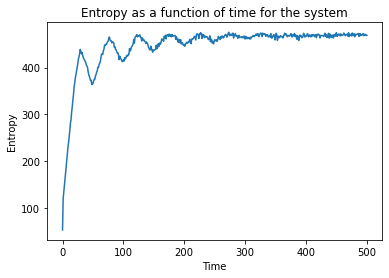

In [22]:
plt.plot(entropies)
plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("Entropy as a function of time for the system")
plt.show()

In [23]:
# The following are test cases for the model:

In [24]:
rows = columns  = 50
config, show_config = initialize(50)

#head on:
#particles = [Particle([20, 25], 3) , particle([30, 25], 0)]

#three-body:

particles = [Particle([30, 30], 5) , Particle([20, 25], 3), Particle([30, 20], 1)]

for partic in particles:
    row, column = partic.position
    config[row, column].particle_contained = [partic]
    config[row, column].vectors[partic.vector]=True
    show_config[row, column]  =config[row, column].get_value()
    
states = []
states.append(np.copy(show_config))
pressured_cells = []
pressured_cells = []

for i in tqdm(range(50)):
    config, show_config, particles, collision_sites = propagation_step(config, show_config,particles)
    config, collision_sites, pressured_cells   = collision_step(config, show_config,collision_sites, pressured_cells)
    config, pressured_cells = scattering(config, show_config,pressured_cells)
    states.append(np.copy(show_config))
    

    


100%|██████████| 50/50 [00:00<00:00, 25136.67it/s]


...........Done!


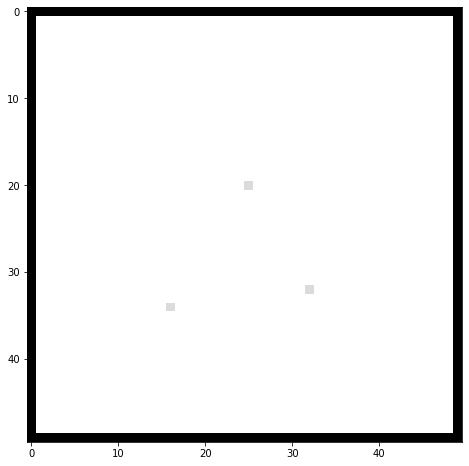

In [25]:
build_animation(states, "try21.mp4")

In [26]:
from IPython.display import Video
Video("try21.mp4")

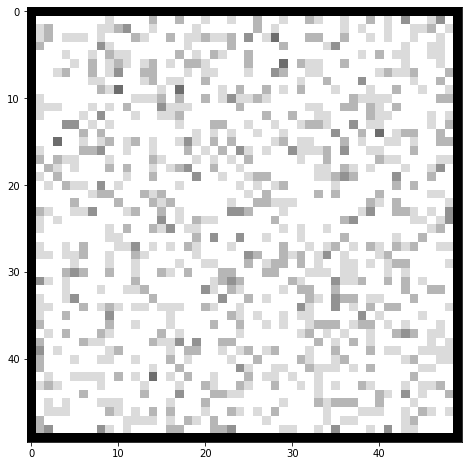

In [27]:
rows = columns = 50
config, show_config = initialize(dimension)
config, particles, show_config = fill_random(dimension, 0.5, 1, config, show_config)

observe(show_config)

In [28]:

vecc = np.vectorize(lambda x: len(x.particle_contained))

states = []
config_states = []
states.append(np.copy(show_config))
config_states.append(copy.deepcopy(config))
pressured_cells = []

for i in tqdm(range(200)):


    config, show_config, particles, collision_sites = propagation_step(config, show_config,particles)
    config, collision_sites, pressured_cells   = collision_step(config, show_config,collision_sites, pressured_cells)
    config, pressured_cells = scattering(config, show_config,pressured_cells)
    states.append(np.copy(show_config))



100%|██████████| 200/200 [00:06<00:00, 30.02it/s]


.........................................Done!


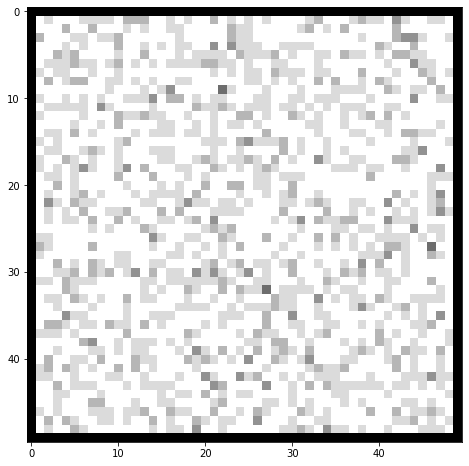

In [29]:
build_animation(states, "try22.mp4")

In [30]:
from IPython.display import Video
Video("try22.mp4")